<a href="https://colab.research.google.com/github/bokutachi256/gisday2021/blob/main/3_%E5%A3%81%E3%82%92%E4%BD%9C%E3%82%8B%5BGISDAY2021%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pythonで作るマルチエージェントシミュレーション
* 東京都立大学 都市環境学部 地理環境学科 中山大地
* 2021年12月4日 東京都立大学 南大沢キャンパス（オンライン開催）
* このテキストのURL [https://github.com/bokutachi256/gisday2021](https://github.com/bokutachi256/gisday2021)
* Google ColaboratoryのURL [https://colab.research.google.com/](https://colab.research.google.com/)
* MESAのURL [https://mesa.readthedocs.io/](https://mesa.readthedocs.io/)

# この章でやること

この章ではスペースに壁を作ります．
避難者エージェントは壁の上に移動するとはできません．

壁は壁エージェントを定義してスペース上に配置することで実現します．
エージェントとして壁を表現することにより，前章の避難者エージェントをほとんど変更することなく
モデルを実装することができます．


# Mesaのインストール

In [ ]:
%pip install mesa

# 必要ライブラリのインポート

In [ ]:
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# ここまでのモデル

## スペースのモデル


前の章で作成したスペースは以下のようになっていました．

* スペースはMultiGridを使う
* ~~エージェントの初期位置はランダムに決定する~~
* エージェントの初期位置は`start_x`と`start_y`とする
* ゴールは`goal_x`と`goal_y`とする
* ~~エージェントは上下左右にランダムに動く~~
* エージェントは上下左右のうち，他の避難者エージェントがいないセルにランダムに動く
* データコレクターには以下の情報を格納する
 * model_reporter：ゴールした人数の累計，Stepごとのゴールした人数
 * agent_reporter：エージェントの座標とゴールしたかどうかの状態を保持


実行してみましょう．

In [ ]:
class EvacModel(Model):
  """A model with some number of agents."""
  # コンストラクタにgoal_xとgoal_yを追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
      
    self.datacollector.collect(self)
     
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)


## ゴール人数の累計を求める関数

こちらも実行します．

In [ ]:

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)


## 避難者エージェントのモデル

避難者エージェントも実行しましょう．

In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0

  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore = False,
      include_center = False)

    # 周囲に移動可能なセルがあるか検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]

    if len(possible_steps2) > 0:
      new_position = self.random.choice(possible_steps2)
    else:
      new_position = self.pos
    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


# 壁を作る

壁は壁エージェントとしてスペースに配置します．
前章にて避難者エージェントは他の避難者エージェントがいないセルに移動できるようにしました．
壁をエージェントとして実装することにより，
避難者エージェントは他のエージェント（他の避難者エージェントと壁エージェント）がいないセルに移動することができます．

このようにマルチエージェントシミュレーションではスペース上の地物をエージェントとして実装する事が一般的です．

## 壁エージェントの定義

壁エージェントも避難者エージェント同様にオブジェクト`Agent`を継承して作成します．
ここでは壁エージェントとして`WallAgent`を定義します．
壁エージェントは動きも必要ないのでコンストラクタのみとします．

In [ ]:
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)

## 壁エージェントをスペースに配置する

壁エージェントを配置するには以下のようにします．
この例ではランダムに10個配置します．  
最初のモデルで避難者エージェントをランダムに配置していたのと同じ方法です．
  
```python
 for i in range(10):
  a = WallAgent(i, self)
  # 壁の位置をランダムに決定する
  x = self.random.randrange(self.grid.width)
  y = self.random.randrange(self.grid.height)
  # エージェントを配置する
  self.grid.place_agent(a, (x, y))
```

また，`EvacModel`に壁の座標を保持するプロパティを追加します．

```python
self.wall_x = list()
self.wall_y = list()
```

実際に壁の座標を取得するには，壁エージェントを配置した後にプロパティに追加します．．
```python
self.wall_x.append(x)
self.wall_y.append(y)
```

壁の生成を追加した`EvacModel`は以下のようになります．
実行しましょう

In [ ]:
class EvacModel(Model):

  # コンストラクタにgoal_xとgoal_yを追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
      
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する（とりあえず5個）
    for i in range(5):
      a = WallAgent(i, self)
      # 壁の位置をランダムに決定する
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # エージェントを配置する
      self.grid.place_agent(a, (x, y))
      # 壁の座標を保持する
      self.wall_x.append(x)
      self.wall_y.append(y)
      
   
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)


## モデルの実行

とりあえず100ステップ実行します．

In [ ]:
# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y)

# 100ステップ実行する
for i in range(100):
  model.step()

## 計算結果をアニメーション表示する

壁の表示部を追加します．
壁のxy座標を保持している`wall_x`と`wall_y`の座標に大きめの■をプロットします．
```python
plt.scatter(model.wall_x, model.wall_y, s = 2000, marker = "s")
```


組み合わせると以下のようになります．

実行しましょう

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size=14, ha='center')
plt.scatter(goal_x, goal_y, s=800, marker="s")

# 壁をプロット
plt.scatter(model.wall_x, model.wall_y, c='gray', s=2000, marker="s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)):
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

避難エージェントが壁をよけて移動する様子がわかります．

## スペースの状態をグラフ化する

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show

# 任意の位置に壁を生成する

前の例では壁をランダムに生成してましたが，任意の位置に壁を作ってみましょう．

## 壁データの準備

壁データとしてnumpyのndarray型式の配列を作成します．
壁は1，通路は０とします．

例えば以下のような壁データは

||x0|x1|x2|x3|x4|
|-|-|-|-|-|-|
|y0|1|0|0|0|0|
|y1|0|0|1|0|0|
|y2|0|1|1|0|1|
|y3|0|0|0|0|0|
|y4|0|1|0|0|0|

このようなndarrayになります．

```python
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])
```

In [ ]:
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

壁を配置するには壁の座標が必要です．
ndarrayは`np.where`を使って任意の値の要素の列番号と行番号を取得できます．
例えば
```python
np.where(wall >0)
```
とすれば,値が０より大である要素の行番号と列番号を取得できます．

In [ ]:
np.where(wall >0)

(array([0, 1, 2, 2, 2, 4]), array([0, 2, 1, 2, 4, 1]))

戻り値は配列のタプルになっており，０番要素が行番号（y），
１番要素が列番号（x）です．

In [ ]:
y = np.where(wall >0)[0]
x = np.where(wall >0)[1]
print(x)
print(y)

[0 2 1 2 4 1]
[0 1 2 2 2 4]


しかし，ndarrayとMesaのスペースは原点の位置が異なります．
ndarrayの原点は左上でMesaのスペースの原点は左下です．
このためndarrayを上限反転しなくてはMesaのスペース上での正しい座標が取得できません．

ndarrayを上下反転するためには`np.flipud`を使います．
上下反転して壁の座標を取得するには以下のようにします．

```python
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
```
壁の座標が取得できたら，取得した座標に壁を配置します．
配置する壁の数は`wall_x`の要素数になります．
要素数は`len`で取得できます．

```python
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
```




## 壁生成を加えたスペース

壁生成を加えたスペースの定義は以下のようになります．
コンストラクタには引数として壁の配列`wall`を加えました．
スペースの外で壁データを作成することによりプログラムに柔軟性を持たせています．

In [ ]:
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)


## モデルの実行

モデルの実行部分で壁を定義しています．
実行してみましょう．

In [ ]:
# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

# モデルの生成，引数として壁の定義を加える
model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y, wall)

# 100ステップ実行する
for i in range(100):
  model.step()

## 計算結果をアニメーション表示する

計算結果のアニメーションも少し改良します．

壁データはndarrayとして与えられているので，
imshowを使ってプロットすることができます．例えば以下のようにです．


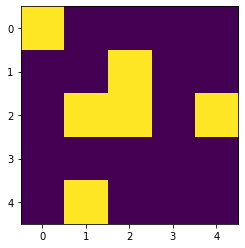

In [ ]:
plt.imshow(wall)

ただし，plt.scatterの原点が左下なのに対し，plt.imshowの原点は左上になっています．
このため，`origin='lower'`を使ってplt.imshowの原点を左下にします．

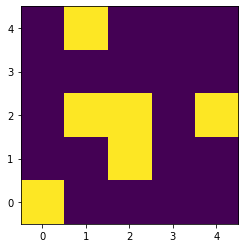

In [ ]:
plt.imshow(wall, origin='lower')

原点は下に来ましたが，画像が上下反転しています．
このため，`np.flipud`を使って壁の配列を上下反転させます．

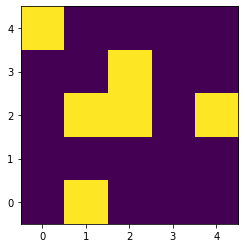

In [ ]:
plt.imshow(np.flipud(wall), origin='lower')

これで`plt.imshow`の壁表示と`plt.scatter`の座標が一致しました．

以上を踏まえて，`plt.imshow`を使って壁を表示するように改良しました．

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size=14, ha='center')
plt.scatter(goal_x, goal_y, s=800, marker="s")

# imshowを使って壁配列を描画する．原点の移動と配列の上下反転を行う．
plt.imshow(np.flipud(wall), origin='lower')

# 壁をプロット
plt.scatter(model.wall_x, model.wall_y, c='gray', s=2000, marker="s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)):
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

## スペースの状態をグラフ化する

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show

# ここまでのまとめ

ここまでの内容をまとめました．

## スペースとエージェントを定義してモデルを実行する

In [ ]:
%pip install mesa
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# スペースの定義
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

# 避難者エージェントの定義
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0

  # エージェントの移動
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore = False,
      include_center = False)

    # 周囲に移動可能なセルがあるか検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]

    if len(possible_steps2) > 0:
      new_position = self.random.choice(possible_steps2)
    else:
      new_position = self.pos
    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()

# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)

# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

# モデルの生成，引数として壁の定義を加える
model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y, wall)

# 100ステップ実行する
for i in range(100):
  model.step()

## 計算結果のアニメーション

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size=14, ha='center')
plt.scatter(goal_x, goal_y, s=800, marker="s")

# imshowを使って壁配列を描画する．原点の移動と配列の上下反転を行う．
plt.imshow(np.flipud(wall), origin='lower')

# 壁をプロット
plt.scatter(model.wall_x, model.wall_y, c='gray', s=2000, marker="s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)):
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

## スペースの状態をグラフ化する

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show